# IA for HumanForYou

L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.

La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :

* Les projets sur lesquels étaient les employés quittant la société prennent du retard ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.

* Un service de ressources humaines de taille conséquente doit être conservé car il faut avoir les moyens de trouver les nouvelles recrues.

* Du temps est perdu à l'arrivée des nouveaux employés car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

Le direction fait donc appel à vous, spécialistes de l'analyse de données, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

### Données fournies

Un certain nombre de données concernant les employés vous a donc été transmis par le service des ressources humaines.

Il s'agit de fichiers textes au format CSV.

Les données ont été anonymisées : un employé de l'entreprise sera représenté par le même EmployeeID dans l'ensemble des fichiers qui suivent.

### Données du service des ressources humaines

Pour chaque employé, le service des ressources humaines vous confie les informations en sa possession :

 - Age : L'âge de l'employé en 2015.

 - Attrition : L'objet de notre étude, est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?

 - BusinessTravel : A quel fréquence l'employé a été amené à se déplacer dans le cadre de son travail en 2015 ? (Non-Travel = jamais, Travel_Rarely= rarement, Travel_Frequently = fréquemment)

 - DistanceFromHome : Distance en km entre le logement de l'employé et l'entreprise.

 - Education : Niveau d'étude : 1=Avant College (équivalent niveau Bac), 2=College (équivalent Bac+2), 3=Bachelor (Bac+3), 4=Master (Bac+5) et 5=PhD (Thèse de doctorat).

 - EducationField : Domaine d'étude, matière principale

 - EmployeeCount : booléen à 1 si l'employé était compté dans les effectifs en 2015.

 - EmployeeId : l'identifiant d'un employé

 - Gender : Sexe de l'employé

 - JobLevel : Niveau hiérarchique dans l'entreprise de 1 à 5

 - JobRole : Métier dans l'entreprise

 - MaritalStatus : Statut marital du salarié (Célibataire, Marié ou Divorcé).

 - MonthlyIncome : Salaire brut en roupies par mois

 - NumCompaniesWorked : Nombre d'entreprises pour lequel le salarié a travaillé avant de rejoindre HumanForYou.

 - Over18 : Est-ce que le salarié a plus de 18 ans ou non ?

 - PercentSalaryHike : % d'augmentation du salaire en 2015.

 - StandardHours : Nombre d'heures par jour dans le contrat du salarié.

 - StockOptionLevel : Niveau d'investissement en actions de l'entreprise par le salarié.

 - TotalWorkingYears : Nombre d'années d'expérience en entreprise du salarié pour le même type de poste.

 - TrainingTimesLastYear : Nombre de jours de formation en 2015

 - YearsAtCompany : Ancienneté dans l'entreprise

 - YearsSinceLastPromotion : Nombre d'années depuis la dernière augmentation individuelle

 - YearsWithCurrentManager : Nombre d'années de collaboration sous la responsabilité du manager actuel de l'employé.

### Importation des données utiles 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import os
import datetime as dt

import tarfile
import zipfile
import urllib.request
from six.moves import urllib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from  sklearn.svm import SVC
from sklearn.metrics import log_loss, make_scorer
import math 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve 
from sklearn.metrics import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
#from prettytable import PrettyTable

In [133]:
from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
#random=default_rng(42) 


DOWNLOAD_ROOT = "https://github.com/Killian-drh/Projet-IA/raw/main/datasets/inoutime/"
INOUTPATH = os.path.join("datasets", "inoutime")
DATA_PATH = "./datasets/"
INOUTIME_URL = DOWNLOAD_ROOT + "in_out_time.zip"

def check_image_folder():
    if not os.path.exists("./images/"):
        os.makedirs("./images/")
        os.makedirs("./images/workflowDS/")
        print ("Images and workflowDS folder has been created")
    elif os.path.exists("./images/"):
        if not os.path.exists("./images/workflowDS/"):
            os.makedirs("./images/workflowDS/")
            print ("WorkflowDS folder has been created")


def fetch_inoutime_data(inoutime_url=INOUTIME_URL, data_path=INOUTPATH):
    in_out_time_check = data_path + "/in_out_time.zip"
    
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    
    if not os.path.exists(in_out_time_check):
        # Download in_out_time.zip from repo github
        zip_path = os.path.join(data_path, "in_out_time.zip")
        urllib.request.urlretrieve(inoutime_url, zip_path)    
        print ("Download Succeed !")

    # specifying the zip file name 
    file_name = './datasets/inoutime/in_out_time.zip'
    
    in_time_check = os.path.exists("./datasets/inoutime/in_time.csv")
    out_time_check = os.path.exists("./datasets/inoutime/out_time.csv")
    
    if in_time_check==False or out_time_check==False: 
    # opening the zip file in READ mode 
        with zipfile.ZipFile(file_name, 'r') as zip: 
          #  printing all the contents of the zip file 
            zip.printdir() 
  
        # extracting all the files 
            print('Extracting all the files now...') 
            zip.extractall(data_path) 
            print('Done!') 
            
    print("Process succeed")
    
check_image_folder()
fetch_inoutime_data()

def load_data(file, data_path=DATA_PATH):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path)

general_df = load_data("general_data.csv")
manager_survey_df = load_data("manager_survey_data.csv")
employee_survey_df = load_data("employee_survey_data.csv")
intime_df = pd.read_csv("./datasets/inoutime/in_time.csv")
outtime_df = pd.read_csv("./datasets/inoutime/out_time.csv")

Process succeed


### Fusion des fichiers csv selon l'ID employé

In [134]:
print(general_df.shape ,  manager_survey_df.shape ,  employee_survey_df.shape)
print(employee_survey_df.columns.tolist())
print(manager_survey_df.columns.tolist())

(4410, 24) (4410, 3) (4410, 4)
['EmployeeID', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
['EmployeeID', 'JobInvolvement', 'PerformanceRating']


In [4]:
df_merge=pd.merge(general_df,employee_survey_df,on='EmployeeID')
df=pd.merge(df_merge,manager_survey_df,on='EmployeeID')

if(len(df.columns.tolist())   == (len(general_df.columns.tolist()) + len(employee_survey_df.columns.tolist()) + len(manager_survey_df.columns.tolist())) - 2):
  print("OK")

OK


In [5]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


Le fichier est a présent complet

### Recheche de valeur null

In [6]:
print("finding whether is there is any nulls in the final_df  if yes how many  {}".format(df.isnull().sum().sum()))
df.dropna(inplace=True)
print("finding whether is there is any nulls in after droping the  final_df  if yes how many  {}".format(df.isnull().any().sum()))

finding whether is there is any nulls in the final_df  if yes how many  111
finding whether is there is any nulls in after droping the  final_df  if yes how many  0


### Recherche de valeur duplication

In [7]:
df_duplicatedRows=df[df.duplicated( keep=False)].shape[0]
if(df_duplicatedRows==0):
  print("Pas de duplicat dans df")
else:
  print("Duplicat dans df")

Pas de duplicat dans df


### Analyse des données

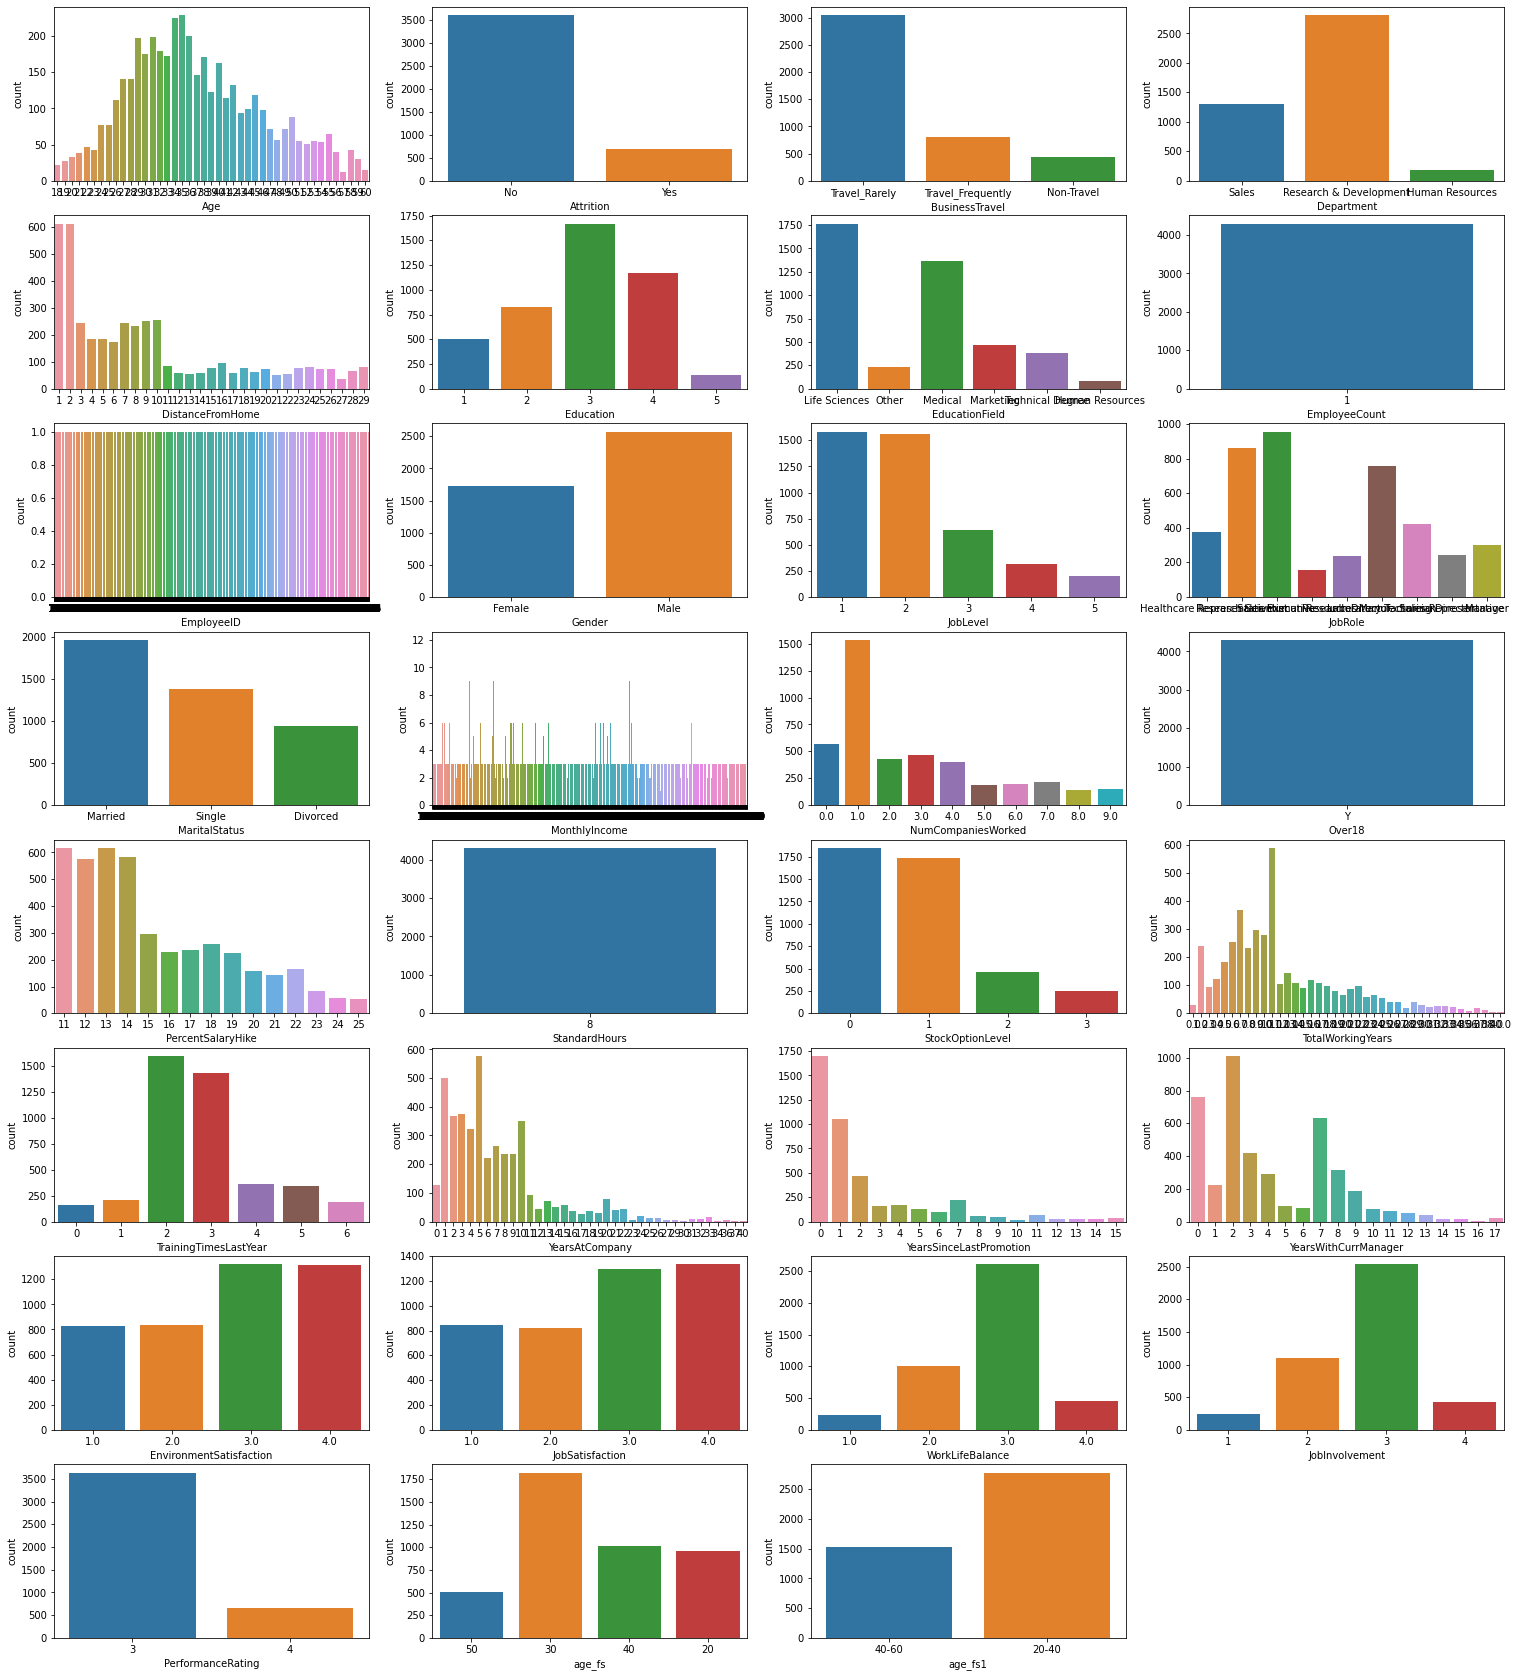

In [135]:
#For all columns doing countplots
fig = plt.figure(figsize=(26,30))
for idx,i in enumerate(df.columns.tolist()):
    ax=plt.subplot(8,4,idx+1)
    sns.countplot(x=i,data=df,ax=ax)
plt.show()

## Analyse des données  | EDA ("Eploratory Data Analysis")

### Analyse des données quantitaves

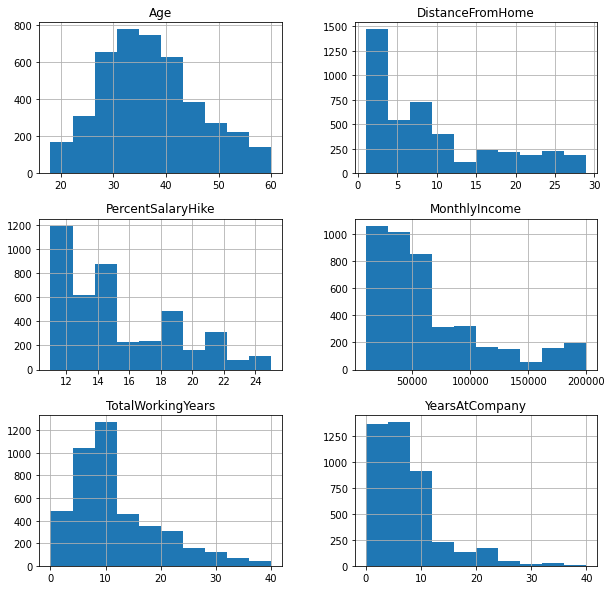

In [136]:
#Divide into NumericalColumns
columns=df.columns.tolist()
num_col_eda=['Age','DistanceFromHome','PercentSalaryHike','MonthlyIncome','TotalWorkingYears','YearsAtCompany']
df[num_col_eda].hist(figsize=(10,10))
plt.show()

### Analyse des données qualitatives

In [137]:
num_attrition=num_col_eda+['Attrition']
Education=['Below-College','College','Bachelor','Master','Doctor']
EnvironmentSatisfaction=['Low','Medium','High','Very High']
JobInvolvement=['Low','Medium','High','Very High']
JobSatisfaction=['Low','Medium','High','Very High']
RelationshipSatisfaction=['Low','Medium','High','Very High']
PerformanceRating=['Low','Good','Excellent','Outstanding']
WorkLifeBalance=['Bad','Good','Better','Best']

val=[Education,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,PerformanceRating,WorkLifeBalance]
cat1=['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating','WorkLifeBalance']

cat_col_eda=set(columns) - set(num_col_eda)
cat_col_eda=set(cat_col_eda) - set(cat1)
fig = plt.figure(figsize=(16,20))

<Figure size 1152x1440 with 0 Axes>

#### for Ordinal Columns doing uni_variant analysis


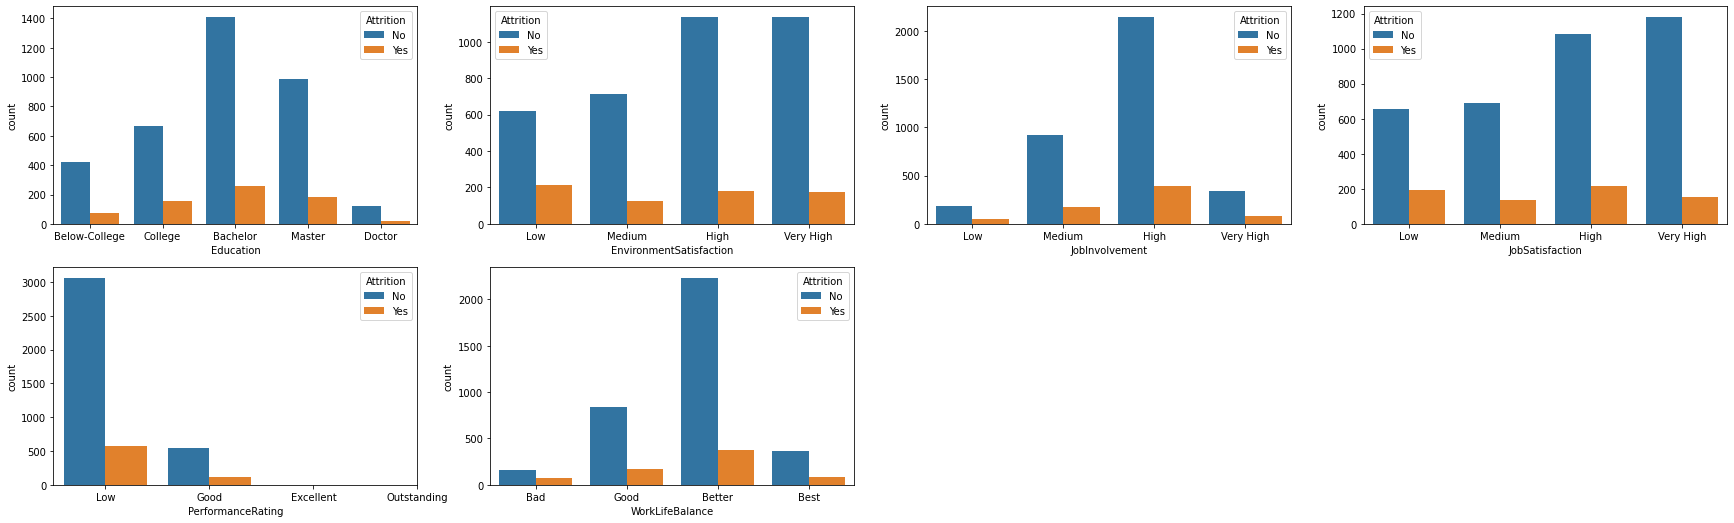

In [138]:
fig = plt.figure(figsize=(30,28))
for idx,i in enumerate(zip(cat1,val)):
    ax=plt.subplot(6,4,idx+1)
    sns.countplot(df[i[0]],hue=df['Attrition'],ax=ax)
    ax.set(xticks=range(len(i[1])), xticklabels=[j for j in i[1]])
plt.show()

#### for nominal_column doing univariant analysis

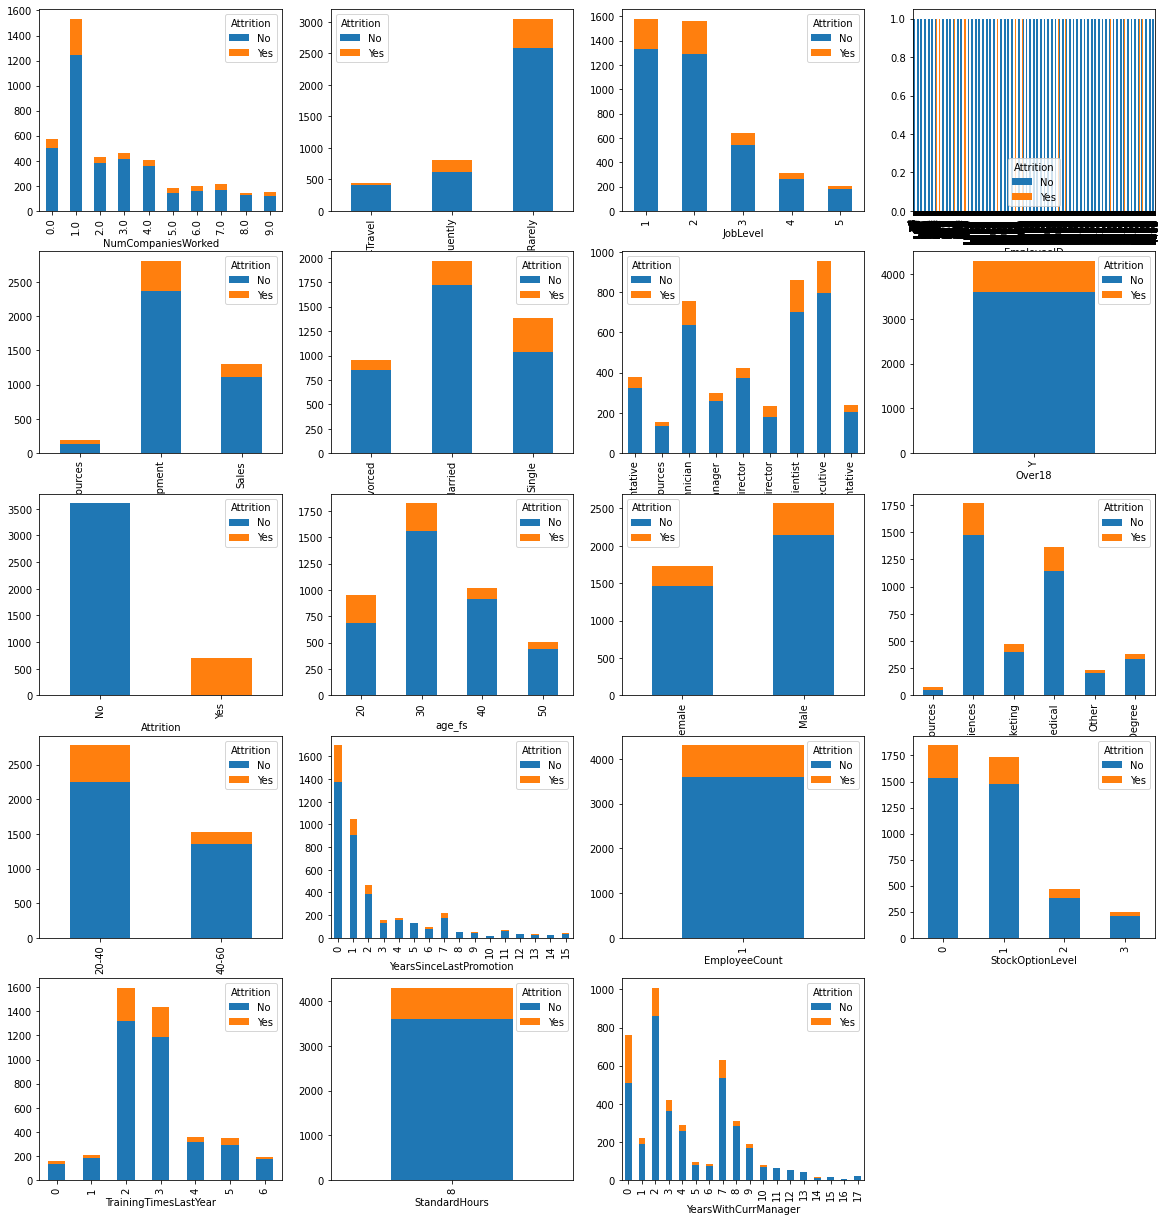

In [139]:
#Divide into CategoricalColumns
#1. with categorys as x_ticks
fig = plt.figure(figsize=(20,26))
for idx,i in enumerate(cat_col_eda):
    crosstab = pd.crosstab(index=df[i], columns=df["Attrition"])
    ax=plt.subplot(6,4,idx+1)
    crosstab.plot(kind="bar",stacked=True,ax=ax)
    #sns.countplot(x=i[0],data=final_df,ax=ax)
    #ax.set(xticks=range(len(i[1])), xticklabels=[j for j in i[1]])
plt.show()

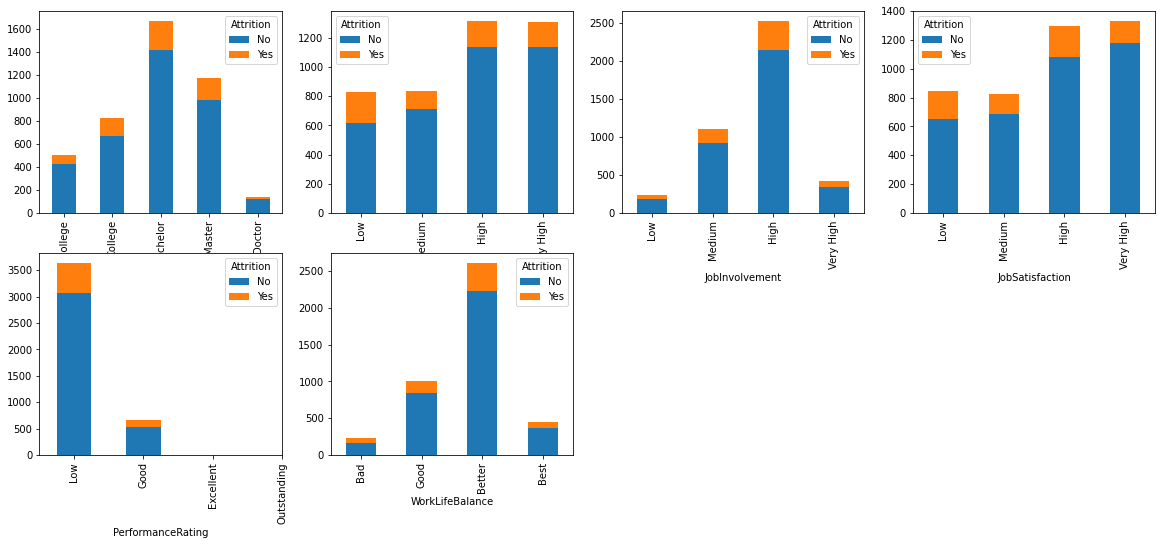

In [140]:
fig = plt.figure(figsize=(20,26))
for idx,i in enumerate(zip(cat1,val)):
    crosstab = pd.crosstab(index=df[i[0]], columns=df["Attrition"])
    ax=plt.subplot(6,4,idx+1)
    crosstab.plot(kind="bar",stacked=True,ax=ax)
    #sns.countplot(x=i[0],data=final_df,ax=ax)
    ax.set(xticks=range(len(i[1])), xticklabels=[j for j in i[1]])
plt.show()

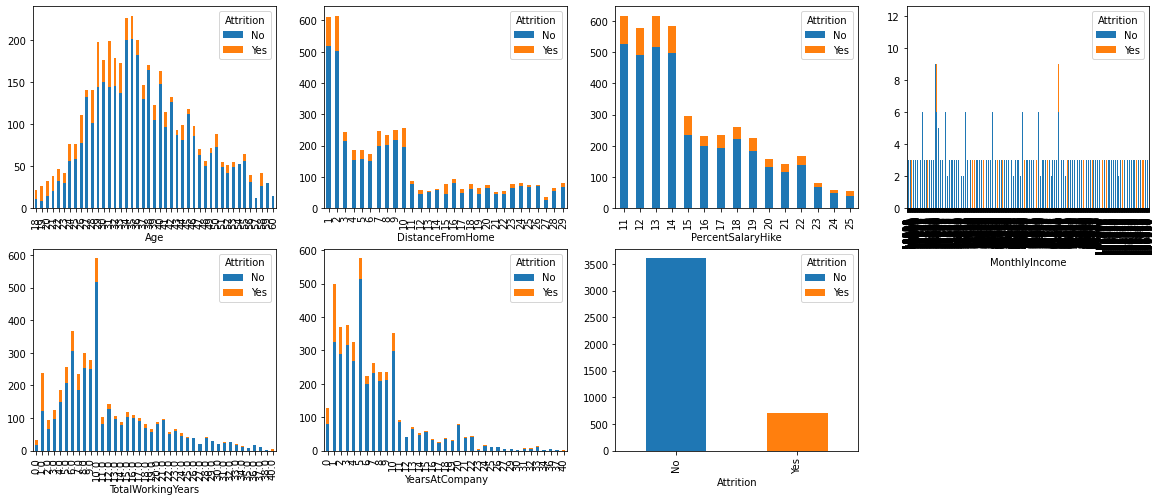

In [141]:
#for i in num_attrition:
#crosstab = pd.crosstab(index=final_df[i], columns=final_df["Attrition"])
#num_attrition=num_col_eda+['Attrition']
fig = plt.figure(figsize=(20,26))
for idx,i in enumerate(num_attrition):
  crosstab = pd.crosstab(index=df[i], columns=df["Attrition"])
  ax=plt.subplot(6,4,idx+1)
    #sns.boxplot(x=i,data=final_df,ax=ax)
  
  crosstab.plot(kind="bar",stacked=True,ax=ax)

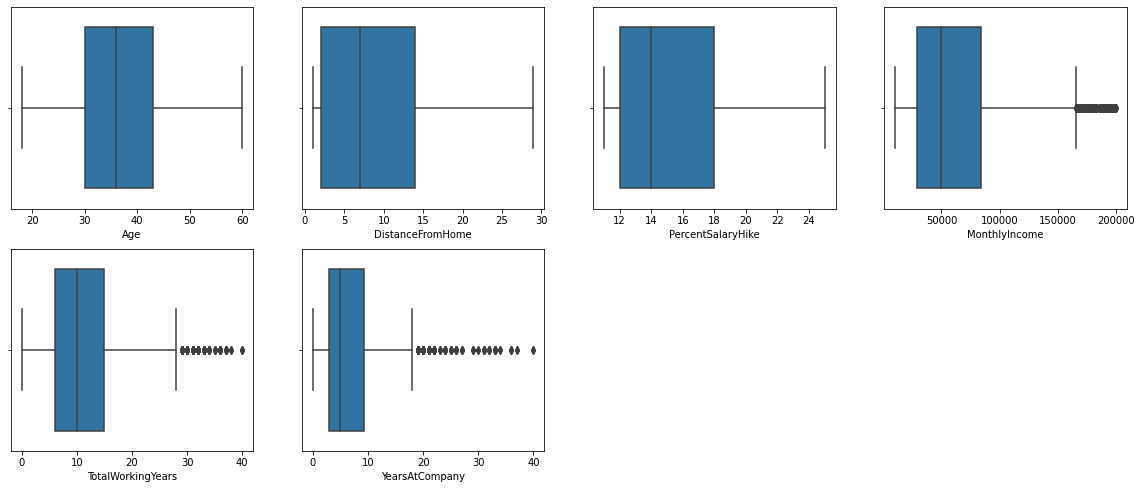

In [142]:
fig = plt.figure(figsize=(20,26))
for idx,i in enumerate(num_col_eda):
    ax=plt.subplot(6,4,idx+1)
    sns.boxplot(x=i,data=df,ax=ax)

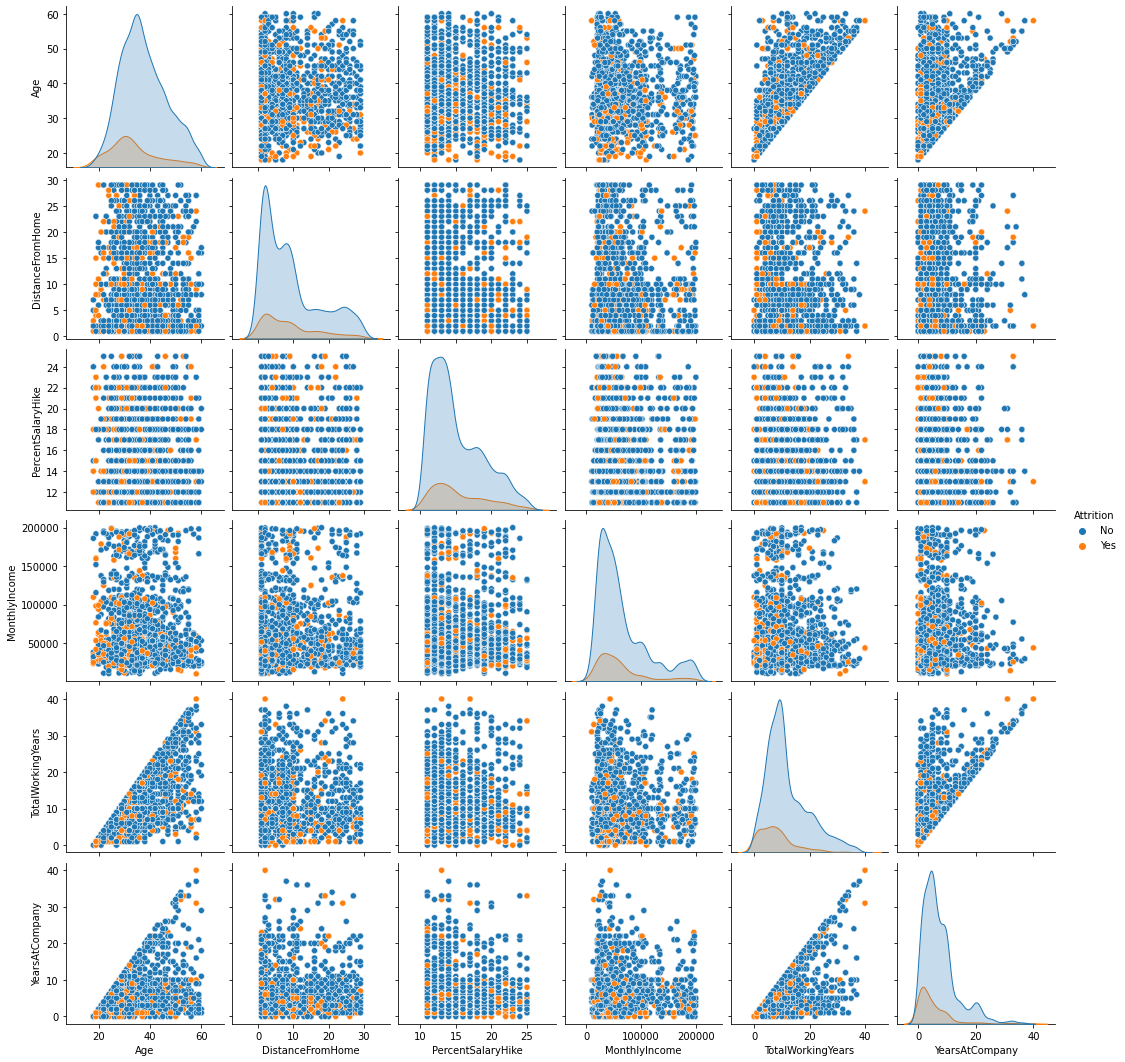

In [143]:
sns.pairplot(df[num_attrition], hue = 'Attrition')

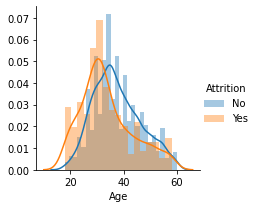

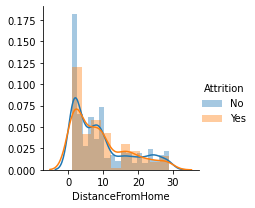

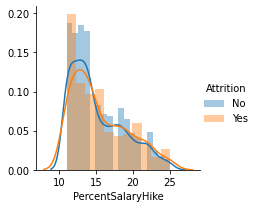

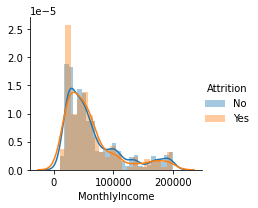

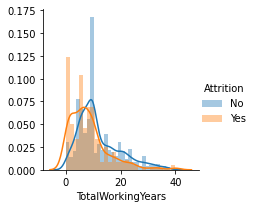

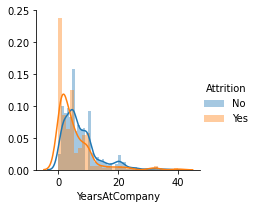

ValueError: could not convert string to float: 'No'

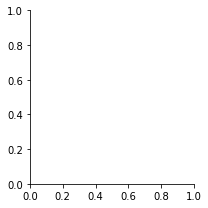

In [144]:
for i in num_attrition:
  sns.FacetGrid(df,hue="Attrition",size=3).map(sns.distplot,i).add_legend()
  plt.show()

### Extraction de données utiles (Age et Attrition)

In [146]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,age_fs,age_fs1
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1,0,0,3.0,4.0,2.0,3,3,50,40-60
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,5,1,4,3.0,2.0,4.0,2,4,30,20-40
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5,0,3,2.0,2.0,1.0,3,3,30,20-40
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,8,7,5,4.0,4.0,3.0,2,3,30,20-40
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,6,0,4,4.0,1.0,3.0,3,3,30,20-40


In [148]:
df['age_fs']=df['Age'].map(lambda x: "20" if(x<30) else ("30" if(30<=x<40) else ("40" if(40<=x<50) else "50")))
#df['age_fs1']=df['Age'].map(lambda x: "20-40" if(x<40) else "40-60")

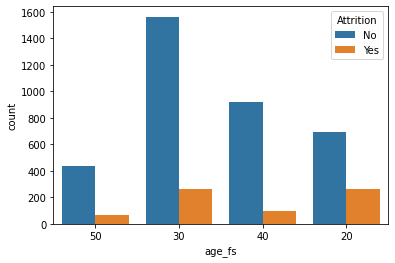

In [149]:
sns.countplot(df["age_fs"],hue=df['Attrition'])
plt.show()

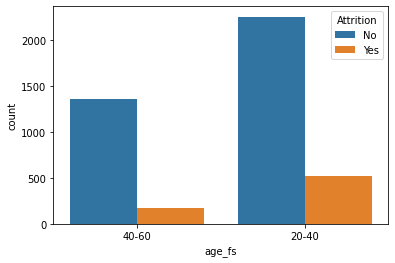

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,age_fs
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3.0,4.0,2.0,3,3,40-60
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,3.0,2.0,4.0,2,4,20-40
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,2.0,2.0,1.0,3,3,20-40
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,4.0,4.0,3.0,2,3,20-40
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,4.0,1.0,3.0,3,3,20-40


In [157]:
df['age_fs']=df['Age'].map(lambda x: "20-40" if(x<40) else "40-60")
sns.countplot(df["age_fs"],hue=df['Attrition'])
plt.show()
df.head()

### Recherche de coorélation entre les données analysées

In [158]:
df_numerical_data = df.copy()
df_numerical_data.drop(['EmployeeCount','StandardHours'], inplace=True, axis=1)

<AxesSubplot:>

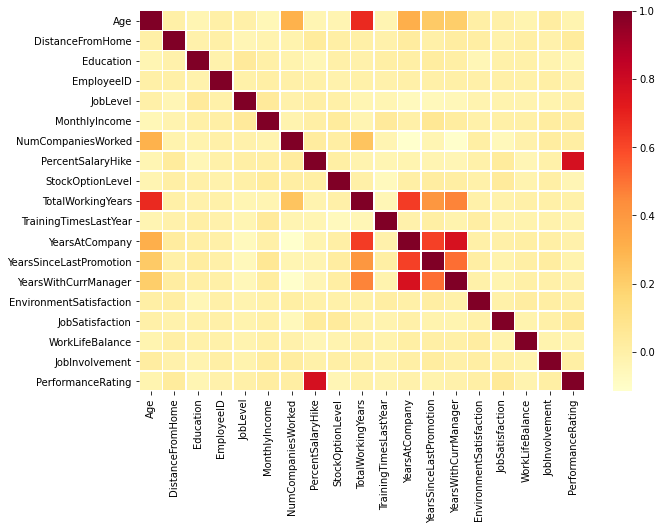

In [159]:
fig, ax = plt.subplots(figsize=(10,7)) 
sns.heatmap(df_numerical_data.corr(),cmap='YlOrRd',linewidths=.5,ax=ax)

## Entrainement de l'algorithme

In [165]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

attrition_label=df['Attrition']print(X_train.shape , X_cv.shape , X_test.shape)

df_train = df.copy()
df_train=df_train.drop('Attrition',1)

attrition_label=attrition_label.map(lambda x : 1 if(x=='Yes') else 0)


X_train, X_test, y_train, y_test = train_test_split(df_train,attrition_label,test_size=0.20,stratify=attrition_label, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train,test_size=0.20,stratify=y_train, random_state=42)

In [166]:
X_train=pd.get_dummies(X_train)
X_cv=pd.get_dummies(X_cv)
X_test=pd.get_dummies(X_test)

In [167]:
print(X_train.shape , X_cv.shape , X_test.shape)

(2752, 50) (688, 50) (860, 50)


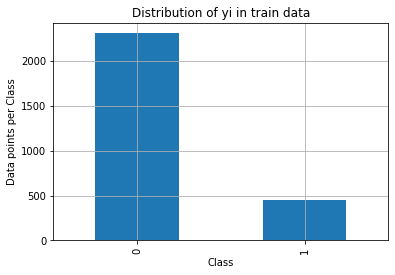

Number of data points in class 0 : 2307 ( 83.83 %)
Number of data points in class 1 : 445 ( 16.17 %)
--------------------------------------------------------------------------------


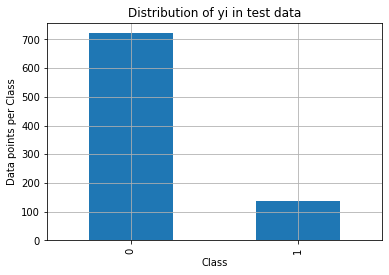

Number of data points in class 1 : 721 ( 83.837 %)
Number of data points in class 2 : 139 ( 16.163 %)
--------------------------------------------------------------------------------


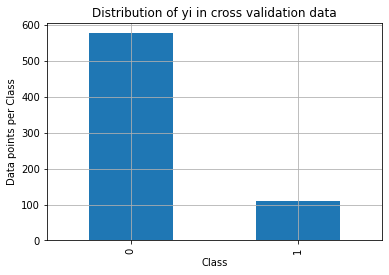

Number of data points in class 1 : 577 ( 83.866 %)
Number of data points in class 2 : 111 ( 16.134 %)


In [60]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts()
test_class_distribution = y_test.value_counts()
cv_class_distribution = y_cv.value_counts()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')

## Machine Learning

In [61]:
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier

### HyperParameter Tuning

In [126]:
def bestHypermeterFunc(algo,x_train,y_train,x_cv,y_cv,x_test,y_test,verborse,kernel_select=None):
  
  print(kernel_select)
  
  #Defining values for HyperParameter 
  alpha = [10 ** x for x in range(-6, 1)]
  C_log=[math.log(i) for i in alpha]
  #Storing Error in Array
  cv_log_error_array = []
  
  
  for i in alpha:
    
    if(verborse==1):
      print("for alpha =", i)
      
    if(algo=='Logistic_Regression'):
      clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
      
    elif(algo=='SVM'):
        clf = SVC(C=i,kernel=kernel_select , probability=True, class_weight='balanced')
        
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    if(verborse==1):
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 
      
  if(verborse==1):
    fig, ax = plt.subplots()
    ax.plot(C_log, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
      ax.annotate((C_log[i],str(txt)[:4]), (C_log[i],np.round(cv_log_error_array[i],2)))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()
  
  return cv_log_error_array,alpha

### desigining ML Ago For the Best Fit HyperParameter Value

In [127]:
def main_model(algo,x_train,y_train,x_cv,y_cv,x_test,y_test,verborse,kernel_select=None):
  
  #calling bestHypermeterFunc and that Function Return's the CVLog_Error Array,alpha
  cv_log_error_array,alpha = bestHypermeterFunc(algo,x_train,y_train,x_cv,y_cv,x_test,y_test,verborse,kernel_select)
  
  print(kernel_select)
  
  print(cv_log_error_array,alpha)
  print("******bestHypermeterFunc Completed********")
  
  #Finding Best HyperParameter  Index  from cv_log_error_array using np.argmin()
  #from that index find its value
  best_alpha = np.argmin(cv_log_error_array)
  print("for best_alpha =", alpha[best_alpha])
  
  #Actual ML ALgorithm Running
  if(algo=='Logistic_Regression'):
    clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
    
  elif(algo=='SVM'):
    clf = SVC(C=alpha[best_alpha],kernel=kernel_select,probability=True, class_weight='balanced')
    
  clf.fit(x_train, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_train, y_train)

  #predicting output Labels for all train,CV and Test Data
  predict_train=sig_clf.predict(x_train)
  predict_cv=sig_clf.predict(x_cv)
  predict_test=sig_clf.predict(x_test)
  
  #Finding LogLoss Metrics For all Data using predictProb values
  predictProb_train = sig_clf.predict_proba(x_train)
  logloss_train=log_loss(y_train, predictProb_train, labels=clf.classes_, eps=1e-15)
  print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",logloss_train)
  
  predictProb_cv = sig_clf.predict_proba(x_cv)
  logloss_cv=log_loss(y_cv, predictProb_cv, labels=clf.classes_, eps=1e-15)
  print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",logloss_cv)
  
  predictProb_test = sig_clf.predict_proba(x_test)
  logloss_test=log_loss(y_test, predictProb_test, labels=clf.classes_, eps=1e-15)
  print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",logloss_test)
  
  if(verborse==1):
  #calling ploting function
    plot_confusion_matrix(y_test,predict_test)
    
  return predict_train,predict_cv,predict_test,logloss_train,logloss_cv,logloss_test,clf

### Function for ploting Confusion Matrix

In [128]:
#0=N0 , 1=Yes
def plot_confusion_matrix(y_test,pred):
  
  labels = [0,1]
  
  #confusion_matrix
  C = confusion_matrix(y_test,pred)
  
  #Recall MAtrix
  A =(((C.T)/(C.sum(axis=1))).T)
  
  #Precision MAtrix
  B =(C/C.sum(axis=0))
  
  # representing A in heatmap format
  lst=[C,A,B]
  lst_names=["Confusion Matrix","Recall","Precision"]
  
  for i in zip(lst,lst_names):
    print("-"*20, i[1], "-"*20)
    plt.figure(figsize=(7,4))
    sns.heatmap(i[0], annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
def bestHypermeterFunc(algo,x_train,y_train,x_cv,y_cv,x_test,y_test,verborse,kernel_select=None):
  
  print(kernel_select)
  
  #Defining values for HyperParameter 
  alpha = [10 ** x for x in range(-6, 1)]
  C_log=[math.log(i) for i in alpha]
  #Storing Error in Array
  cv_log_error_array = []
  
  
  for i in alpha:
    
    if(verborse==1):
      print("for alpha =", i)
      
    if(algo=='Logistic_Regression'):
      clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
      
    elif(algo=='SVM'):
        clf = SVC(C=i,kernel=kernel_select , probability=True, class_weight='balanced')
        
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    if(verborse==1):
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 
      
  if(verborse==1):
    fig, ax = plt.subplots()
    ax.plot(C_log, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
      ax.annotate((C_log[i],str(txt)[:4]), (C_log[i],np.round(cv_log_error_array[i],2)))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()
  
  return cv_log_error_array,alpha
def bestHypermeterFunc(algo,x_train,y_train,x_cv,y_cv,x_test,y_test,verborse,kernel_select=None):
  
  print(kernel_select)
  
  #Defining values for HyperParameter 
  alpha = [10 ** x for x in range(-6, 1)]
  C_log=[math.log(i) for i in alpha]
  #Storing Error in Array
  cv_log_error_array = []
  
  
  for i in alpha:
    
    if(verborse==1):
      print("for alpha =", i)
      
    if(algo=='Logistic_Regression'):
      clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
      
    elif(algo=='SVM'):
        clf = SVC(C=i,kernel=kernel_select , probability=True, class_weight='balanced')
        
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    if(verborse==1):
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 
      
  if(verborse==1):
    fig, ax = plt.subplots()
    ax.plot(C_log, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
      ax.annotate((C_log[i],str(txt)[:4]), (C_log[i],np.round(cv_log_error_array[i],2)))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()
  
  return cv_log_error_array,alpha

In [129]:
from prettytable import PrettyTable

def metrics(algo,X_train_scalar,y_train,X_cv_scalar,y_cv,X_test_scalar,y_test,verbrose,kernel_select=None):
  
  predict_train,predict_cv,predict_test,logloss_train,logloss_cv,logloss_test,clf=main_model(algo,X_train_scalar,y_train,X_cv_scalar,y_cv,X_test_scalar,y_test,verbrose,kernel_select)
  
  accuracy_train=accuracy_score(y_train,predict_train)
  accuracy_cv=accuracy_score(y_cv,predict_cv)
  accuracy_test=accuracy_score(y_test,predict_test)
  
  precision_train=precision_score(y_train,predict_train)
  precision_cv=precision_score(y_cv,predict_cv)
  precision_test=precision_score(y_test,predict_test)
  
  recall_train=recall_score(y_train,predict_train)
  recall_cv=recall_score(y_cv,predict_cv)
  recall_test=recall_score(y_test,predict_test)
  
  F1Score_train=f1_score(y_train,predict_train)
  F1Score_cv=f1_score(y_cv,predict_cv)
  F1Score_test=f1_score(y_test,predict_test)
  
  x = PrettyTable()
  x.field_names = ["Metric", "Train_value" , "CV_value","Test_value"]
  
  x.add_row([ "Log-Loss" ,   np.round(logloss_train,3)  ,   np.round(logloss_cv,3)    ,   np.round(logloss_test,3) ])
  x.add_row([ "Precision" ,  np.round(precision_train,3) ,   np.round(precision_cv,3)  ,  np.round(precision_test,3) ])
  x.add_row([ "Recall" ,     np.round(recall_train,3) ,      np.round(recall_cv,3)     ,  np.round(recall_test,3)])
  x.add_row([ "F1-Score" ,   np.round(F1Score_train,3) ,     np.round(F1Score_cv,3)     , np.round(F1Score_test,3)])
  x.add_row([ "Accuracy" ,    np.round(accuracy_train,3)  ,   np.round(accuracy_cv,3)    ,   np.round(accuracy_test,3) ])
  
  print(x)
  
  print("Starting Get Important Features Function")
  get_imp_features(clf,kernel_select)

### Function to Print Important Features

In [130]:
def get_imp_features(clf,kernel_select):
  
  print(kernel_select)
  if((kernel_select == 'rbf' ) or (kernel_select == 'poly')):
    
    
    print(" Kernel is {} so, we cannot get the important Features using Coef_ Funtion".format(kernel_select))

    
  else:
        
    coefs=sorted(zip(clf.coef_[0],X_train.columns.tolist()))
    feat=X_train.columns.tolist()
               
    top10Negative=coefs[:10]
    top10Postive=coefs[::-1][:10]

    res_neg=pd.DataFrame(top10Negative,columns=['Values','Top10NegativeFeatures'])
    res_pos=pd.DataFrame(top10Postive,columns=['Values','Top10PostiveFeatures'])
    res=pd.concat([res_neg,res_pos],axis=1)
  
    print("*"*20)
    #print(len(feat))
    #print(len(coefs))
  
    feat=[i[1] for i in coefs]
    coefs1=[i[0] for i in coefs]
    plt.figure(figsize=(10,14))
    plt.barh(range(len(feat)), coefs1, align='center')
    plt.yticks(range(len(feat)), feat)
    plt.show()
  
  #return res

### StandardScaler Function

In [131]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scalar=scaler.transform(X_train)
X_cv_scalar=scaler.transform(X_cv)
X_test_scalar=scaler.transform(X_test)

### Logistic Regression Using Function

None
None
[0.40477211662409224, 0.4066697062936244, 0.4014985684389675, 0.38237343079467584, 0.38278590118940325, 0.3868140867498914, 0.39486982518110386] [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
******bestHypermeterFunc Completed********
for best_alpha = 0.001
For values of best alpha =  0.001 The train log loss is: 0.3547321822294364
For values of best alpha =  0.001 The cross validation log loss is: 0.38237343079467584
For values of best alpha =  0.001 The test log loss is: 0.37067205875116765
+-----------+-------------+----------+------------+
|   Metric  | Train_value | CV_value | Test_value |
+-----------+-------------+----------+------------+
|  Log-Loss |    0.355    |  0.382   |   0.371    |
| Precision |    0.726    |  0.727   |    0.65    |
|   Recall  |    0.155    |  0.144   |   0.094    |
|  F1-Score |    0.256    |  0.241   |   0.164    |
|  Accuracy |    0.854    |  0.853   |   0.845    |
+-----------+-------------+----------+------------+
Starting Get Important Feat

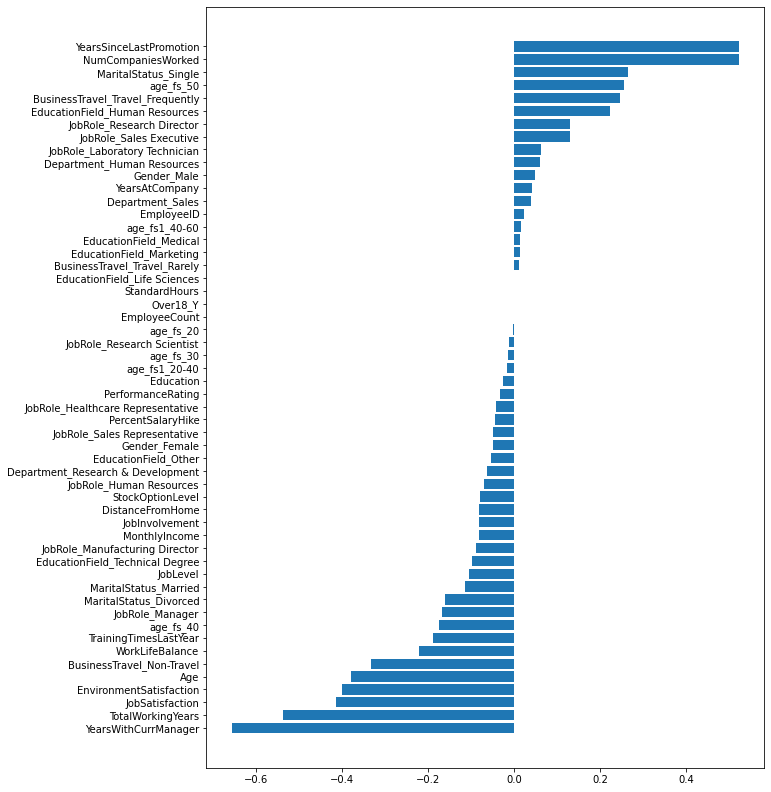

In [132]:
metrics("Logistic_Regression",X_train_scalar,y_train,X_cv_scalar,y_cv,X_test_scalar,y_test,0)

### SVM
#### Using Linear Kernal

linear
linear
[0.4014215174727286, 0.40142151768155715, 0.40142151779851276, 0.3872573969535298, 0.3876649785614324, 0.38678199750585546, 0.38672630953166715] [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
******bestHypermeterFunc Completed********
for best_alpha = 1
For values of best alpha =  1 The train log loss is: 0.35617697429830775
For values of best alpha =  1 The cross validation log loss is: 0.38672630953166715
For values of best alpha =  1 The test log loss is: 0.3691089742369164
+-----------+-------------+----------+------------+
|   Metric  | Train_value | CV_value | Test_value |
+-----------+-------------+----------+------------+
|  Log-Loss |    0.356    |  0.387   |   0.369    |
| Precision |    0.625    |   0.68   |    0.52    |
|   Recall  |    0.124    |  0.153   |   0.094    |
|  F1-Score |    0.206    |   0.25   |   0.159    |
|  Accuracy |    0.846    |  0.852   |    0.84    |
+-----------+-------------+----------+------------+
Starting Get Important Features Functio

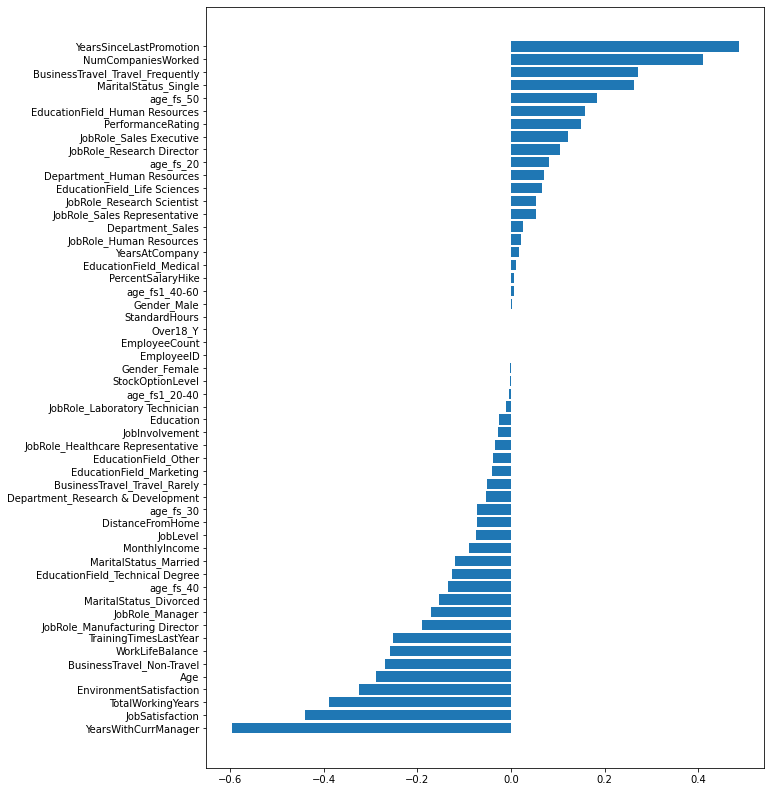

In [69]:
metrics("SVM",X_train_scalar,y_train,X_cv_scalar,y_cv,X_test_scalar,y_test,0,"linear")

In [70]:
metrics("SVM",X_train_scalar,y_train,X_cv_scalar,y_cv,X_test_scalar,y_test,0,"rbf")

rbf
rbf
[0.3979741386558265, 0.39797414021754696, 0.39797414110091095, 0.39797413729691167, 0.3979741408595205, 0.370136554551635, 0.2353843661114351] [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
******bestHypermeterFunc Completed********
for best_alpha = 1
For values of best alpha =  1 The train log loss is: 0.11008191242391002
For values of best alpha =  1 The cross validation log loss is: 0.2353843661114351
For values of best alpha =  1 The test log loss is: 0.19474130438104953
+-----------+-------------+----------+------------+
|   Metric  | Train_value | CV_value | Test_value |
+-----------+-------------+----------+------------+
|  Log-Loss |     0.11    |  0.235   |   0.195    |
| Precision |    0.888    |  0.798   |   0.868    |
|   Recall  |    0.946    |  0.676   |   0.755    |
|  F1-Score |    0.916    |  0.732   |   0.808    |
|  Accuracy |    0.972    |   0.92   |   0.942    |
+-----------+-------------+----------+------------+
Starting Get Important Features Function
rbf
 K

In [71]:
metrics("SVM",X_train_scalar,y_train,X_cv_scalar,y_cv,X_test_scalar,y_test,0,"poly")

poly
poly
[0.40984557541874755, 0.40984557517992654, 0.40984557464893606, 0.4098455735112234, 0.4087475361048691, 0.3110465968776366, 0.1949745011664347] [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
******bestHypermeterFunc Completed********
for best_alpha = 1
For values of best alpha =  1 The train log loss is: 0.0769562971990032
For values of best alpha =  1 The cross validation log loss is: 0.1949745011664347
For values of best alpha =  1 The test log loss is: 0.16279927612418074
+-----------+-------------+----------+------------+
|   Metric  | Train_value | CV_value | Test_value |
+-----------+-------------+----------+------------+
|  Log-Loss |    0.077    |  0.195   |   0.163    |
| Precision |    0.953    |  0.873   |   0.894    |
|   Recall  |    0.964    |  0.802   |   0.849    |
|  F1-Score |    0.959    |  0.836   |   0.871    |
|  Accuracy |    0.987    |  0.949   |   0.959    |
+-----------+-------------+----------+------------+
Starting Get Important Features Function
poly

### KNeighbours

In [56]:
#metrics("KNeighbors",X_train_scalar,y_train,X_cv_scalar,y_cv,X_test_scalar,y_test,0)

## Balanced Data

In [78]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_balance, y_train_balance = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_balance.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_balance.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_balance==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_balance==0)))

Before OverSampling, counts of label '1': 445
Before OverSampling, counts of label '0': 2307 

After OverSampling, the shape of train_X: (4614, 54)
After OverSampling, the shape of train_y: (4614,) 

After OverSampling, counts of label '1': 2307
After OverSampling, counts of label '0': 2307


In [79]:
scaler = StandardScaler()
scaler.fit(X_train_balance)
X_train_scalar=scaler.transform(X_train_balance)
X_cv_scalar=scaler.transform(X_cv)
X_test_scalar=scaler.transform(X_test)

In [80]:
X_train_scalar.shape

(4614, 54)

None
None
[0.405483774135419, 0.4089075250915705, 0.39761035418414364, 0.39074336650172703, 0.39076515601275835, 0.3983857116229877, 0.4248604207953848] [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
******bestHypermeterFunc Completed********
for best_alpha = 0.001
For values of best alpha =  0.001 The train log loss is: 0.2640408961453888
For values of best alpha =  0.001 The cross validation log loss is: 0.39074336650172703
For values of best alpha =  0.001 The test log loss is: 0.39086675825194905
+-----------+-------------+----------+------------+
|   Metric  | Train_value | CV_value | Test_value |
+-----------+-------------+----------+------------+
|  Log-Loss |    0.264    |  0.391   |   0.391    |
| Precision |    0.985    |  0.731   |   0.682    |
|   Recall  |    0.792    |  0.171   |   0.108    |
|  F1-Score |    0.878    |  0.277   |   0.186    |
|  Accuracy |     0.89    |  0.856   |   0.848    |
+-----------+-------------+----------+------------+
Starting Get Important Featur

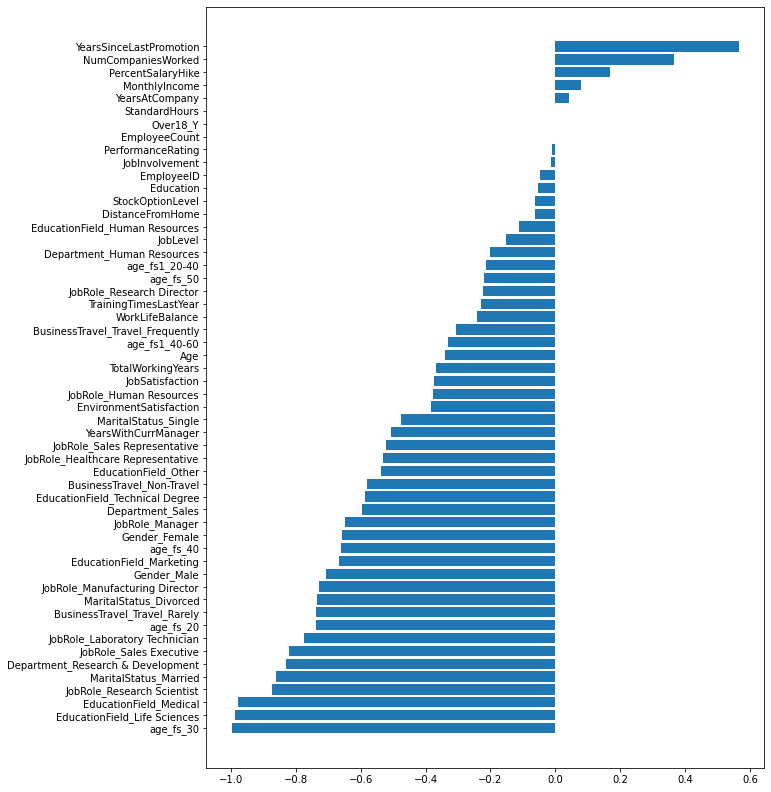

In [81]:
metrics("Logistic_Regression",X_train_scalar,y_train_balance,X_cv_scalar,y_cv,X_test_scalar,y_test,0)

linear
for alpha = 1e-06
Log Loss : 0.46525266350775457
for alpha = 1e-05
Log Loss : 0.4652526657634241
for alpha = 0.0001
Log Loss : 0.4371899103461773
for alpha = 0.001
Log Loss : 0.39103365438564025
for alpha = 0.01
Log Loss : 0.3862496130809934
for alpha = 0.1
Log Loss : 0.3869633921745674
for alpha = 1
Log Loss : 0.38919355387456533


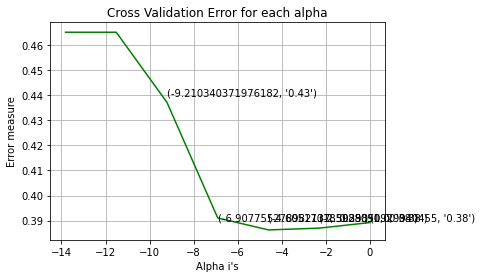

linear
[0.46525266350775457, 0.4652526657634241, 0.4371899103461773, 0.39103365438564025, 0.3862496130809934, 0.3869633921745674, 0.38919355387456533] [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
******bestHypermeterFunc Completed********
for best_alpha = 0.01
For values of best alpha =  0.01 The train log loss is: 0.26581577214857205
For values of best alpha =  0.01 The cross validation log loss is: 0.3862496130809934
For values of best alpha =  0.01 The test log loss is: 0.39152345702344593
-------------------- Confusion Matrix --------------------


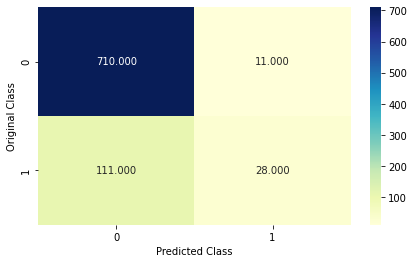

-------------------- Recall --------------------


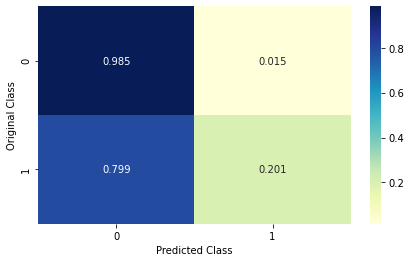

-------------------- Precision --------------------


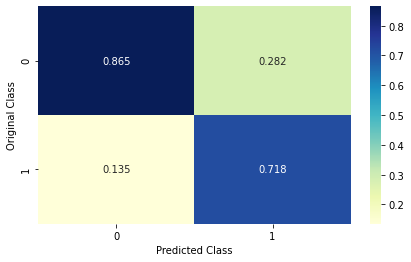

+-----------+-------------+----------+------------+
|   Metric  | Train_value | CV_value | Test_value |
+-----------+-------------+----------+------------+
|  Log-Loss |    0.266    |  0.386   |   0.392    |
| Precision |    0.977    |  0.613   |   0.718    |
|   Recall  |    0.806    |  0.171   |   0.201    |
|  F1-Score |    0.883    |  0.268   |   0.315    |
|  Accuracy |    0.894    |  0.849   |   0.858    |
+-----------+-------------+----------+------------+
Starting Get Important Features Function
linear
********************


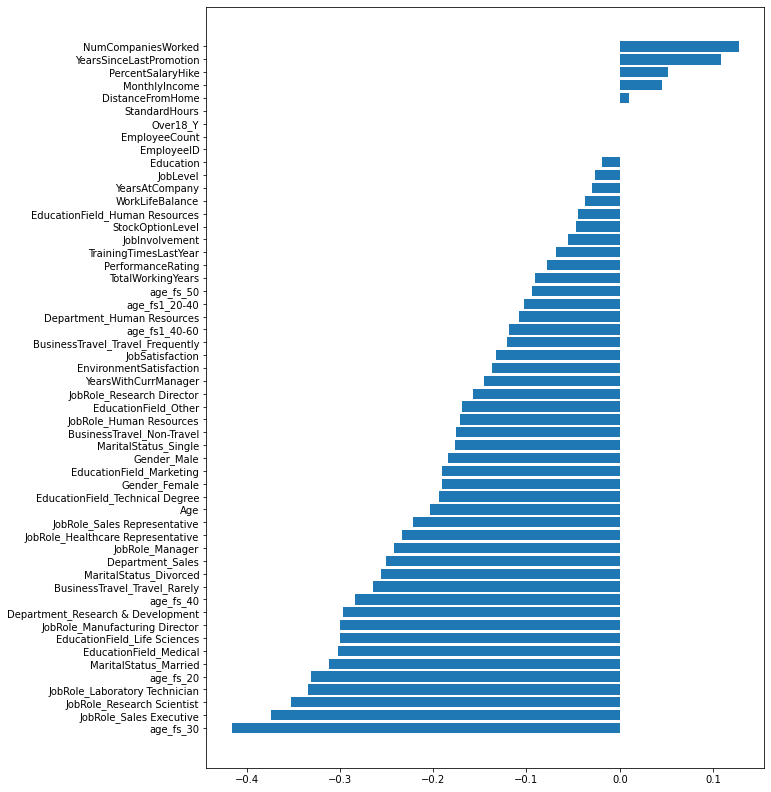

In [82]:
metrics("SVM",X_train_scalar,y_train_balance,X_cv_scalar,y_cv,X_test_scalar,y_test,1,"linear")

rbf
for alpha = 1e-06
Log Loss : 0.4723031932670974
for alpha = 1e-05
Log Loss : 0.47230319275261257
for alpha = 0.0001
Log Loss : 0.4723031920388279
for alpha = 0.001
Log Loss : 0.47230319249900715
for alpha = 0.01
Log Loss : 0.4572493164809867
for alpha = 0.1
Log Loss : 0.3914318947186938
for alpha = 1
Log Loss : 0.27876359017930313


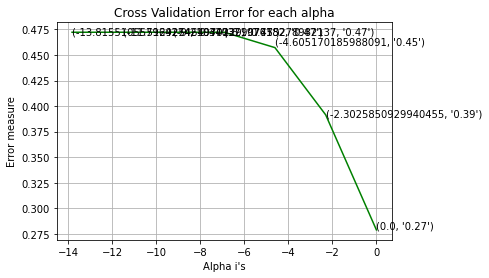

rbf
[0.4723031932670974, 0.47230319275261257, 0.4723031920388279, 0.47230319249900715, 0.4572493164809867, 0.3914318947186938, 0.27876359017930313] [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
******bestHypermeterFunc Completed********
for best_alpha = 1
For values of best alpha =  1 The train log loss is: 0.08826455766499369
For values of best alpha =  1 The cross validation log loss is: 0.27876359017930313
For values of best alpha =  1 The test log loss is: 0.2752419647263068
-------------------- Confusion Matrix --------------------


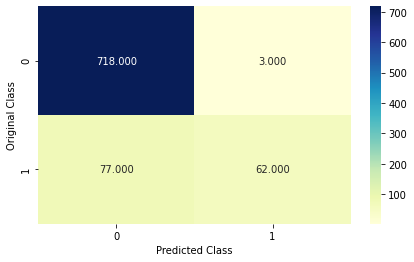

-------------------- Recall --------------------


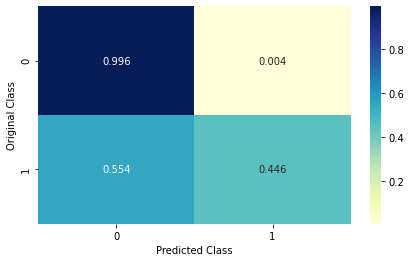

-------------------- Precision --------------------


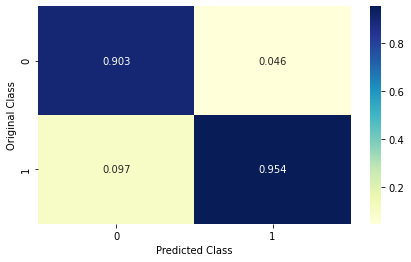

+-----------+-------------+----------+------------+
|   Metric  | Train_value | CV_value | Test_value |
+-----------+-------------+----------+------------+
|  Log-Loss |    0.088    |  0.279   |   0.275    |
| Precision |    0.999    |  0.913   |   0.954    |
|   Recall  |    0.947    |  0.378   |   0.446    |
|  F1-Score |    0.972    |  0.535   |   0.608    |
|  Accuracy |    0.973    |  0.894   |   0.907    |
+-----------+-------------+----------+------------+
Starting Get Important Features Function
rbf
 Kernel is rbf so, we cannot get the important Features using Coef_ Funtion


In [83]:
metrics("SVM",X_train_scalar,y_train_balance,X_cv_scalar,y_cv,X_test_scalar,y_test,1,"rbf")
